In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

## Examine data

In [2]:
%%capture
df = pd.read_csv('clinvar_20180225.ann.tsv.gz', compression='gzip', sep='\t', error_bad_lines=False, header=0)

In [3]:
len(df)

372159

In [4]:
df.head()

,#id,chrom,inputPos,inputRef,inputAlt,unannotatedReason,gene,geneId,geneDesc,transcript,...,granthamDist,AGVGDclass,AGVGDgv,AGVGDgd,SIFTprediction,SIFTweight,SIFTmedian,MAPPprediction,MAPPpValue,MAPPpValueMedian
0,475283,1,949422,G,A,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,46.0,C0,178.468,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,183381,1,949523,C,T,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,475278,1,949597,C,T,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,402986,1,949608,G,A,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,46.0,C0,130.977,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,161455,1,949696,C,CG,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.dtypes

#id                       int64
chrom                    object
inputPos                  int64
inputRef                 object
inputAlt                 object
unannotatedReason        object
gene                     object
geneId                    int64
geneDesc                 object
transcript               object
strand                    int64
transLen                  int64
cdsLen                    int64
protein                  object
Uniprot                  object
varType                  object
codingEffect             object
varLocation              object
assembly                 object
gDNAstart                 int64
gDNAend                   int64
gNomen                   object
cDNAstart                object
cDNAend                  object
cNomen                   object
pNomen                   object
alt_pNomen               object
exon                      int64
intron                  float64
omimId                  float64
                         ...   
wtAA_3  

In [6]:
df.isnull().sum()

#id                          0
chrom                        0
inputPos                     0
inputRef                     0
inputAlt                     0
unannotatedReason            0
gene                         0
geneId                       0
geneDesc                     0
transcript                   0
strand                       0
transLen                     0
cdsLen                       0
protein                  16608
Uniprot                  88433
varType                      0
codingEffect            131716
varLocation                  0
assembly                     0
gDNAstart                    0
gDNAend                      0
gNomen                       0
cDNAstart                    0
cDNAend                      0
cNomen                       0
pNomen                    2380
alt_pNomen                2380
exon                         0
intron                  318115
omimId                   21182
                         ...  
wtAA_3                  158696
wtCodon 

## Preprocessing

### Filters

In [7]:
RELEVANT_FEATURES = [
    'chrom',
    'inputPos',
    'inputRef',
    'inputAlt',
    'transcript',
    'codingEffect',
    'varLocation',
    'alt_pNomen',
    'wtSSFScore',
    'wtMaxEntScore',
    'varSSFScore',
    'varMaxEntScore',
#     'rsId',
#     'rsClinicalSignificance',
    'rsMAF',
    '1000g_AF',
    'gnomadAltFreq_all',
    'espAllMAF',
    'espAllAAF',
    'clinVarMethods',
    'clinVarClinSignifs',
    'nOrthos',
    'conservedOrthos'
]


RULES = [
    lambda df: df['codingEffect'] != 'synonymous',
    lambda df: df['varLocation'] != 'intron',
    lambda df: np.invert(df['1000g_AF'] > 0.01),
    lambda df: np.invert(df['gnomadAltFreq_all'] > 0.01)
]


def rules_filter(df):
    for rule in RULES:
        df = df[rule(df)]
    return df


df = df[RELEVANT_FEATURES]  # Filtering relevant features
df = rules_filter(df)  # Rules filtering
df.reset_index(drop=True, inplace=True)
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,varMaxEntScore,rsMAF,1000g_AF,gnomadAltFreq_all,espAllMAF,espAllAAF,clinVarMethods,clinVarClinSignifs,nOrthos,conservedOrthos
0,1,949422,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,7.04863,0.006190,0.006190,0.001599,0.005459,0.005459,NaN,NaN,10.0,2.0
1,1,949523,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,Pathogenic,NaN,NaN
2,1,949696,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,Pathogenic,NaN,NaN
3,1,949739,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,7.04863,0.000000,NaN,0.000008,NaN,NaN,literature only,Pathogenic,NaN,NaN
4,1,949851,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,7.04863,0.000799,0.000799,0.000265,0.000698,0.000698,NaN,NaN,10.0,2.0


### `inputPos` as regression parametr

In [8]:
df.inputPos = df.inputPos.astype(float)

### `clinVarMethods` split

In [9]:
def fetch_names(row, delimeters='|,'):
    def unify(name):
        return '_'.join(name.strip().lower().split())
    
    names = [row]
    for delimeter in delimeters:
        new_names = []
        for name in names:
            new_names.extend(name.split(delimeter))
        names = new_names
    return [unify(name) for name in names]


def collect_names(column, delimeters='|,'): 
    all_names = set()
    for row in column:
        all_names.update(set(fetch_names(row)))
    return all_names

In [10]:
df.clinVarMethods = df.clinVarMethods.fillna('NaN')
cvm_methods = {m: i for i, m in enumerate(list(collect_names(df.clinVarMethods)))}
cvm_features = []
for row in df.clinVarMethods:
    row_features = np.zeros(len(cvm_methods))
    for name in fetch_names(row):
        row_features[cvm_methods[name]] += 1
    cvm_features.append(row_features)
cvm_features = np.vstack(cvm_features)

cvm_columns = ['cvm_' + m for _, m in sorted([(i, m) for m, i in cvm_methods.items()])]
cvm_features = pd.DataFrame(cvm_features, columns=cvm_columns)
df = pd.concat([df, cvm_features], axis=1)
del df['clinVarMethods']
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_provider_interpretation,cvm_research,cvm_curation,cvm_in_vitro,cvm_nan,cvm_not_provided,cvm_case-control,cvm_phenotyping_only,cvm_clinical_testing,cvm_reference_population
0,1,949422.0,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,949851.0,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Making target

In [11]:
def binarize_target(y, bad_word='pathogenic'):
    return y.apply(lambda x: int(bad_word in x.lower()))

In [12]:
df = df.loc[df.clinVarClinSignifs.notna()]
df.reset_index(drop=True, inplace=True)
df.rename({'clinVarClinSignifs': 'y'}, axis=1, inplace=True)
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_provider_interpretation,cvm_research,cvm_curation,cvm_in_vitro,cvm_nan,cvm_not_provided,cvm_case-control,cvm_phenotyping_only,cvm_clinical_testing,cvm_reference_population
0,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,955563.0,G,C,NM_001305275.1,missense,exon,p.Arg4Pro,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,955596.0,C,G,NM_001305275.1,missense,exon,p.Pro15Arg,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## TT split

In [13]:
def tt_split(df):
    np.random.seed(42)
    df = df.copy()
    
    y = binarize_target(df.y)
    del df['y']
    X = df
    
    X = X.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
    X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, test_size=0.2)
    
    cat_features = np.where(X.dtypes != np.float)[0]

    return (X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features

## NDCG

In [14]:
relevances = {'benign': 0, 'likely benign': 1, 'not provided': 2, 'vus': 2, 'likely pathogenic': 3, 'pathogenic': 4}


def split_relevance(relevance):
    return [r.lower() for it in relevance.split('|') for r in it.split(', ') if r.lower() in relevances]


def get_relevances(significances):
    return [split_relevance(significance) for significance in significances.values]


def dcg(relevances):
    return np.sum(2 ** relevances / np.log2(np.arange(2, relevances.size + 2)))


def evaluate_serp(df, sign, score, n=30):
    serp = df.sample(n=n, replace=False)
    rel_true = np.array([relevances[np.random.choice(sign[index], size=1)[0]] for index, row in serp.iterrows()])

    order_true = np.argsort(rel_true)[::-1]
    serp = serp.iloc[order_true]
    rel_true = rel_true[order_true]

    order_pred = np.argsort(score[serp.index])[::-1]
    rel_pred = rel_true[order_pred]
    
    return dcg(rel_pred) / dcg(rel_true)


def evaluate(df, sign, score, k=1000, n=30):
    np.random.seed(42)
    return np.mean([evaluate_serp(df, sign, score, n) for _ in range(k)])

In [15]:
sign = pd.Series(data=get_relevances(df.y), index=df.index)
not_empty = [it != [] for it in sign]
df = df[not_empty]
sign = sign[not_empty]
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_provider_interpretation,cvm_research,cvm_curation,cvm_in_vitro,cvm_nan,cvm_not_provided,cvm_case-control,cvm_phenotyping_only,cvm_clinical_testing,cvm_reference_population
0,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,955563.0,G,C,NM_001305275.1,missense,exon,p.Arg4Pro,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,955596.0,C,G,NM_001305275.1,missense,exon,p.Pro15Arg,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Run

In [16]:
(X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features = tt_split(df)
len(X_train), len(X_validate), len(X_test)

(126179, 31545, 39431)

In [17]:
model = CatBoostClassifier(iterations=500)

In [18]:
model.fit(X_train, y_train, cat_features=cat_features, 
          use_best_model=True, eval_set=(X_validate, y_validate));

0:	learn: 0.6637162	test: 0.6635067	best: 0.6635067 (0)	total: 335ms	remaining: 2m 47s
1:	learn: 0.6366035	test: 0.6361876	best: 0.6361876 (1)	total: 578ms	remaining: 2m 23s
2:	learn: 0.6112460	test: 0.6107853	best: 0.6107853 (2)	total: 854ms	remaining: 2m 21s
3:	learn: 0.5894326	test: 0.5887126	best: 0.5887126 (3)	total: 1.1s	remaining: 2m 16s
4:	learn: 0.5681653	test: 0.5673011	best: 0.5673011 (4)	total: 1.27s	remaining: 2m 5s
5:	learn: 0.5445802	test: 0.5433632	best: 0.5433632 (5)	total: 1.49s	remaining: 2m 2s
6:	learn: 0.5216982	test: 0.5196154	best: 0.5196154 (6)	total: 1.72s	remaining: 2m 1s
7:	learn: 0.5020929	test: 0.4994018	best: 0.4994018 (7)	total: 1.98s	remaining: 2m 1s
8:	learn: 0.4834816	test: 0.4802441	best: 0.4802441 (8)	total: 2.13s	remaining: 1m 56s
9:	learn: 0.4667086	test: 0.4627407	best: 0.4627407 (9)	total: 2.38s	remaining: 1m 56s
10:	learn: 0.4501271	test: 0.4455023	best: 0.4455023 (10)	total: 2.62s	remaining: 1m 56s
11:	learn: 0.4354998	test: 0.4304555	best: 0.4

93:	learn: 0.2155336	test: 0.2035656	best: 0.2035656 (93)	total: 24.1s	remaining: 1m 44s
94:	learn: 0.2151312	test: 0.2032074	best: 0.2032074 (94)	total: 24.4s	remaining: 1m 44s
95:	learn: 0.2147041	test: 0.2027806	best: 0.2027806 (95)	total: 24.7s	remaining: 1m 43s
96:	learn: 0.2142559	test: 0.2024119	best: 0.2024119 (96)	total: 25s	remaining: 1m 43s
97:	learn: 0.2138973	test: 0.2020561	best: 0.2020561 (97)	total: 25.3s	remaining: 1m 43s
98:	learn: 0.2132650	test: 0.2014651	best: 0.2014651 (98)	total: 25.6s	remaining: 1m 43s
99:	learn: 0.2130179	test: 0.2012162	best: 0.2012162 (99)	total: 25.9s	remaining: 1m 43s
100:	learn: 0.2126191	test: 0.2008625	best: 0.2008625 (100)	total: 26.1s	remaining: 1m 43s
101:	learn: 0.2122362	test: 0.2005472	best: 0.2005472 (101)	total: 26.4s	remaining: 1m 43s
102:	learn: 0.2119762	test: 0.2002924	best: 0.2002924 (102)	total: 26.7s	remaining: 1m 43s
103:	learn: 0.2114633	test: 0.1997667	best: 0.1997667 (103)	total: 27s	remaining: 1m 42s
104:	learn: 0.210

184:	learn: 0.1940070	test: 0.1838781	best: 0.1838781 (184)	total: 52.9s	remaining: 1m 30s
185:	learn: 0.1937653	test: 0.1836603	best: 0.1836603 (185)	total: 53.3s	remaining: 1m 29s
186:	learn: 0.1936939	test: 0.1835932	best: 0.1835932 (186)	total: 53.5s	remaining: 1m 29s
187:	learn: 0.1935546	test: 0.1834455	best: 0.1834455 (187)	total: 53.9s	remaining: 1m 29s
188:	learn: 0.1934781	test: 0.1834005	best: 0.1834005 (188)	total: 54.1s	remaining: 1m 29s
189:	learn: 0.1932289	test: 0.1831893	best: 0.1831893 (189)	total: 54.4s	remaining: 1m 28s
190:	learn: 0.1930663	test: 0.1830322	best: 0.1830322 (190)	total: 54.7s	remaining: 1m 28s
191:	learn: 0.1929228	test: 0.1829085	best: 0.1829085 (191)	total: 55.1s	remaining: 1m 28s
192:	learn: 0.1928520	test: 0.1828240	best: 0.1828240 (192)	total: 55.3s	remaining: 1m 28s
193:	learn: 0.1927605	test: 0.1827495	best: 0.1827495 (193)	total: 55.6s	remaining: 1m 27s
194:	learn: 0.1926280	test: 0.1826208	best: 0.1826208 (194)	total: 55.9s	remaining: 1m 27s

275:	learn: 0.1858068	test: 0.1767323	best: 0.1767323 (275)	total: 1m 20s	remaining: 1m 4s
276:	learn: 0.1857377	test: 0.1766839	best: 0.1766839 (276)	total: 1m 20s	remaining: 1m 4s
277:	learn: 0.1856728	test: 0.1766401	best: 0.1766401 (277)	total: 1m 20s	remaining: 1m 4s
278:	learn: 0.1856036	test: 0.1766079	best: 0.1766079 (278)	total: 1m 20s	remaining: 1m 4s
279:	learn: 0.1855071	test: 0.1765155	best: 0.1765155 (279)	total: 1m 21s	remaining: 1m 3s
280:	learn: 0.1854769	test: 0.1764931	best: 0.1764931 (280)	total: 1m 21s	remaining: 1m 3s
281:	learn: 0.1854323	test: 0.1764515	best: 0.1764515 (281)	total: 1m 21s	remaining: 1m 3s
282:	learn: 0.1853822	test: 0.1764186	best: 0.1764186 (282)	total: 1m 22s	remaining: 1m 3s
283:	learn: 0.1853290	test: 0.1763851	best: 0.1763851 (283)	total: 1m 22s	remaining: 1m 2s
284:	learn: 0.1852412	test: 0.1763142	best: 0.1763142 (284)	total: 1m 22s	remaining: 1m 2s
285:	learn: 0.1851879	test: 0.1762746	best: 0.1762746 (285)	total: 1m 23s	remaining: 1m 2s

366:	learn: 0.1807785	test: 0.1727095	best: 0.1727095 (366)	total: 1m 48s	remaining: 39.3s
367:	learn: 0.1807563	test: 0.1726952	best: 0.1726952 (367)	total: 1m 48s	remaining: 39s
368:	learn: 0.1806875	test: 0.1726342	best: 0.1726342 (368)	total: 1m 49s	remaining: 38.7s
369:	learn: 0.1806746	test: 0.1726240	best: 0.1726240 (369)	total: 1m 49s	remaining: 38.4s
370:	learn: 0.1806167	test: 0.1725667	best: 0.1725667 (370)	total: 1m 49s	remaining: 38.1s
371:	learn: 0.1805781	test: 0.1725488	best: 0.1725488 (371)	total: 1m 49s	remaining: 37.8s
372:	learn: 0.1805127	test: 0.1724943	best: 0.1724943 (372)	total: 1m 50s	remaining: 37.5s
373:	learn: 0.1805029	test: 0.1724907	best: 0.1724907 (373)	total: 1m 50s	remaining: 37.2s
374:	learn: 0.1804826	test: 0.1724844	best: 0.1724844 (374)	total: 1m 50s	remaining: 37s
375:	learn: 0.1804287	test: 0.1724501	best: 0.1724501 (375)	total: 1m 51s	remaining: 36.7s
376:	learn: 0.1803907	test: 0.1724202	best: 0.1724202 (376)	total: 1m 51s	remaining: 36.4s
377

457:	learn: 0.1777629	test: 0.1705435	best: 0.1705435 (457)	total: 2m 16s	remaining: 12.6s
458:	learn: 0.1776538	test: 0.1704473	best: 0.1704473 (458)	total: 2m 17s	remaining: 12.3s
459:	learn: 0.1776012	test: 0.1704153	best: 0.1704153 (459)	total: 2m 17s	remaining: 12s
460:	learn: 0.1775746	test: 0.1703999	best: 0.1703999 (460)	total: 2m 17s	remaining: 11.7s
461:	learn: 0.1775627	test: 0.1703889	best: 0.1703889 (461)	total: 2m 18s	remaining: 11.4s
462:	learn: 0.1775190	test: 0.1703642	best: 0.1703642 (462)	total: 2m 18s	remaining: 11.1s
463:	learn: 0.1774934	test: 0.1703500	best: 0.1703500 (463)	total: 2m 18s	remaining: 10.8s
464:	learn: 0.1774356	test: 0.1702941	best: 0.1702941 (464)	total: 2m 19s	remaining: 10.5s
465:	learn: 0.1774305	test: 0.1702945	best: 0.1702941 (464)	total: 2m 19s	remaining: 10.2s
466:	learn: 0.1774013	test: 0.1702831	best: 0.1702831 (466)	total: 2m 19s	remaining: 9.87s
467:	learn: 0.1773160	test: 0.1702009	best: 0.1702009 (467)	total: 2m 19s	remaining: 9.57s
4

In [19]:
y_pred = model.predict(X_test)
(y_pred == y_test).sum() / len(y_test)

0.9332504881945677

In [20]:
score = pd.Series(data=y_pred, index=X_test.index)
evaluate(X_test, sign, score)

0.9613995085719519

## Analysis

In [21]:
def draw_importance(columns, importances):
    order = np.argsort(importances)
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    plt.show()

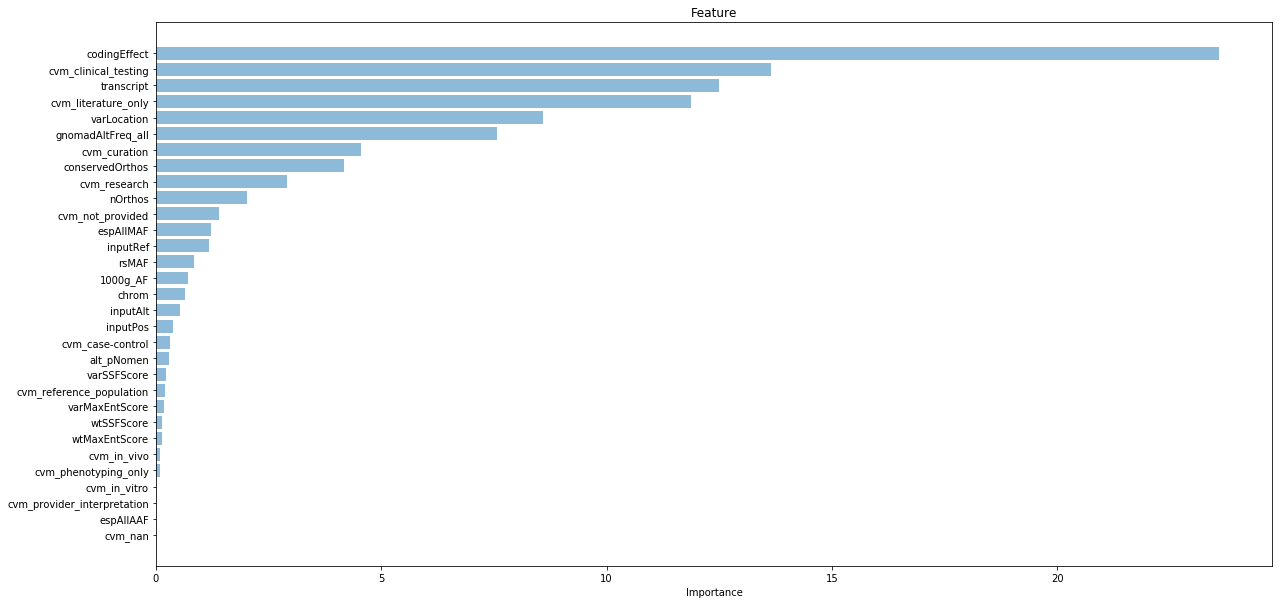

In [22]:
draw_importance(X_train.columns, model.feature_importances_)